In [81]:
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from profanityfilter import ProfanityFilter
import string
pf = ProfanityFilter()
%matplotlib inline

In [2]:
DATA_FOLDER = "data/"
CSV_FOLDER = "newdata_csv/"
categories = {"american_renaissance_comments":"Questionable Source",
                 "alex_jones_comments":"Conspiracy-Pseudoscience",
                "russia_today_comments":"Questionable Source",
                "prager_u_comments":"PragerU",
                "bbc_comments":"Left-Center Bias",
                 "breitbart_comments":"Questionable Source",
                 "democracy_now_comments":"Left Bias",
                "numberphile_comments":"Apolitical",
                "the_dodo_comments":"Apolitical",
                 "the_new_york_times_comments":"Left-Center Bias",
                 "the_guardian_comments":"Left-Center Bias",
                "young_turks_comments":"Left Bias",
                "syriana_analysis_comments":"Left Bias",
                "science_magazine_comments":"Pro-Science",
                "fox_news_comments":"Right Bias"}

In [3]:
class Analyzer(object):
    """Analyzer class"""
    def __init__(self, data_filename):
        super(Analyzer, self).__init__()
        self.filename = data_filename
        self.data = self.load_data(self.filename)
        self.comments_df = self.get_comments_df()

    def load_data(self, name):
        """Returns data from data folder

        Keyword arguments:
        name -- name of file without extension
        """
        with open(DATA_FOLDER + name + '.pkl', 'rb') as f:
            return pickle.load(f)

    def pretty_print_video_data(self, title):
        """Print all comments and metadata of video

        Keyword arguments:
        title -- title of video
        """
        d = self.data
        if title not in d:
            print("Title not found.")

        v_url, video_comments, stats = d[title]

        print("Video Title: %s" % title)
        print("Video URL: %s" % v_url)
        print("Video Metadata: ")
        print("| Publish Date: %s" % stats[0])
        print("| Channel Title: %s" % stats[1])
        print("| Duration: %s" % stats[2])
        print("| View Count: %s" % stats[3])
        print("| Like Count: %s" % stats[4])
        print("| Dislike Count: %s" % stats[5])
        print("| Favorite Count: %s" % stats[6])
        print("")
        for i in range(len(video_comments)):
            comment_dict = video_comments[i]
            print("Comment number %d:" % i)
            print("Author, Timestamp: (%s, %s)" % (comment_dict['original comment'][0][0], comment_dict['original comment'][0][1]))
            print("Like Count: %s" % comment_dict['original comment'][0][2])
            print(comment_dict['original comment'][1])
            print("-------")
            num_replies = len(comment_dict['replies'])
            print("Replies (%d of them)" % num_replies)
            for r in comment_dict['replies'][::-1]:
                print("Author, timestamp: (%s, %s)" % (r[0][0], r[0][1]))
                print("Like Count: %s" % r[0][2])
                print(r[1])
                print("---")
            print("===========")
            print("")

    def pretty_print_first_n(self, n):
        """Pretty print first n videos

        Keyword arguments:
        n -- number of videos to pretty print
        """
        d = self.data
        print("Number of total videos: %d" % len(d))
        for key in list(d.keys())[:n]:
            self.pretty_print_video_data(key)
            print("=====================")
            print("=====================")
            print("")

    def get_comments_df(self):
        """Convert data to pandas dataframe of all comments.
        Returns the pandas comment dataframe
        """
        csv_name = CSV_FOLDER + self.filename + ".csv"
        if os.path.isfile(csv_name):
            df = pd.read_csv(csv_name, lineterminator='\n')
            return df

        columns=["Comment", "Author", "Video_Title", "Timestamp",
            "Like_Count", "Is_Reply", "Num_Replies", "Parent"]
        df = pd.DataFrame(columns=columns)
        com_num = 0
        print("Converting Videos to Pandas Dataframe")
        print("Number of videos:")
        print(len(list(self.data.keys())))

        cntr = -1
        for key in self.data:
            cntr += 1
            if cntr % 10 == 0:
                print("completed " + str(cntr))
            v_url, video_comments, stats = self.data[key]
            for comment_dict in video_comments:
                author = comment_dict['original comment'][0][0]
                timestamp = comment_dict['original comment'][0][1]
                like_cnt = comment_dict['original comment'][0][2]
                com_text = comment_dict['original comment'][1]
                is_reply = False
                num_replies = len(comment_dict['replies'])
                df.loc[com_num] = pd.Series({
                    "Comment": com_text,
                    "Author": author,
                    "Video_Title": key,
                    "Timestamp": timestamp,
                    "Like_Count": like_cnt,
                    "Is_Reply": is_reply,
                    "Num_Replies": num_replies
                })
                parent = com_num

                com_num +=1

                for r in comment_dict['replies'][::-1]:
                    author = r[0][0]
                    timestamp = r[0][1]
                    like_cnt = r[0][2]
                    com_text = r[1]
                    is_reply = True
                    num_replies = 0
                    df.loc[com_num] = pd.Series({
                        "Comment": com_text,
                        "Author": author,
                        "Video_Title": key,
                        "Timestamp": timestamp,
                        "Like_Count": like_cnt,
                        "Is_Reply": is_reply,
                        "Num_Replies": num_replies,
                        "Parent": parent
                    })
                    com_num +=1
        df.to_csv(csv_name)
        return df

    def get_duplicates(self):
        """Return Dataframe containing all duplicate comments
        """
        df = self.comments_df
        text = df["Comment"]
        dups = df[text.isin(text[text.duplicated()])].sort_values(by="Comment")
        return dups

    def get_most_replied_comments(self, top_n):
        """Plots users by number of replies on their comments

        Keyword arguments:

        hide_range -- range of num replies to hide
        """
        df = self.comments_df
        top = df.nlargest(top_n, 'Num_Replies')
        top = top.drop_duplicates()
        pd.set_option('max_colwidth',1000)
        return top

    def get_most_liked_comments(self, top_n):
        """Plots users by number of replies on their comments

        Keyword arguments:

        hide_range -- range of num replies to hide
        """
        df = self.comments_df
        top = df.nlargest(top_n, 'Like_Count')
        top = top.drop_duplicates()
        pd.set_option('max_colwidth',1000)
        return top

    def plot_comment_length(self, hide_n):
        """Plots users by number of replies on their comments

        Keyword arguments:

        hide_range -- range of num replies to hide
        """
        df = self.comments_df
        comment_col = df["Comment"]
        comment_lengths = []
        for comm in comment_col:
            if (len(comm) > hide_n):
                comment_lengths.append(len(comm))
        plt.hist(comment_lengths, 100)
        plt.title("Comment Length")
        plt.show()


    def plot_users_vs_replies(self, hide_range=[0,0]):
        """Plots users by number of replies on their comments

        Keyword arguments:

        hide_range -- range of num replies to hide
        """
        users = {}
        d = self.data
        for key in d.keys():
            v_comments = d[key][1]
            for comment in v_comments:
                author = comment['original comment'][0][0]
                if author not in users:
                    users[author] = 0
                num_replies = len(comment['replies'])
                users[author] += num_replies

        values = list(users.values())
        values_nozeroes = []
        ran = list(range(hide_range[0], hide_range[1] + 1))
        for val in values:
            if val not in ran:
                values_nozeroes.append(val)
        plt.hist(values_nozeroes, bins = 'auto')
        plt.ylabel("# of users")
        plt.xlabel("# of comments")
        plt.title("Users versus Total Replies to User")
        plt.show()

    def big_user_comment(self):
        """Plot their # of comments over all the videos and the number of videos they commented on.
        Return the top 30 big users.

        """
        df = self.comments_df
        user_direct = df.loc[df.Parent.isnull()].groupby('Author').count()['Comment']
        user_reply = df.loc[~df.Parent.isnull()].groupby('Author').count()['Comment']
        user = df.groupby('Author').count()['Comment']
        user = pd.DataFrame(user)
        user['user_direct'] = user_direct
        user['user_reply'] = user_reply
        user['Video number']=df[['Author','Video Title']].drop_duplicates().groupby('Author').count()
        user = user.sort_values('Comment',ascending=False)
        user[['user_direct','user_reply','Video number']][:15].plot(kind='bar')
        return user[:15]

    def baby_vader(self):
        df = self.comments_df
        sid = SentimentIntensityAnalyzer()
        score_list=[]
        for i in list(df[:14000].index):
            c = df.iloc[i].Comment
            k = sid.polarity_scores(c)['compound']
            score_list.append(k)

        sns.distplot(score_list,kde=False)

    def pull_conversation_user(self):
        for i in self.comments_df.Parent.unique()[1:]: # be careful, usually the first element is NA
            b = self.comments_df[self.comments_df.Parent==i].groupby('Author').count()['Comment']
            b = pd.DataFrame(b[b>1])
            if len(b)>1:
                b['Parent']=[i]*len(b)
                b['Parent Author'] = [self.comments_df.iloc[int(i)].Author]*len(b)
                try:
                    reply_alot = reply_alot.append(b)
                except NameError:
                    reply_alot = b
        return reply_alot

bad_words = pf.get_profane_words()
def is_profane(comment, bad_words):
    prof = {}
    count = 0
    for word in bad_words:
        prof[word.lower()] = True
    for word in comment.split():
        lower = word.lower()
        without_punc = ''.join(ch for ch in lower if ch not in set(string.punctuation))
        if prof.get(lower, False) or prof.get(without_punc, False):
            return 100.0
    return 0.0

In [4]:
dataset_names = ["democracy_now_comments",
                 "young_turks_comments",
                "syriana_analysis_comments",
                 "the_new_york_times_comments",
                 "the_guardian_comments",
                 "bbc_comments",
                 "fox_news_comments",
                 "prager_u_comments",
                 "alex_jones_comments",
                "russia_today_comments",                
                 "breitbart_comments",
                 "american_renaissance_comments",
                 "science_magazine_comments",
                "numberphile_comments",
                "the_dodo_comments"]
tools = []
frames = []
#Get Analysis tool for each dataset
for name in dataset_names:
    print("name: ", name)
    obj = Analyzer(name)
    tools.append(obj)
    print(len(obj.data.keys()))
    frames.append(obj.comments_df[~obj.comments_df.Timestamp.isnull()])

name:  democracy_now_comments
201
name:  young_turks_comments
201
name:  syriana_analysis_comments
201
name:  the_new_york_times_comments
201
name:  the_guardian_comments
201
name:  bbc_comments
201
name:  fox_news_comments
200
name:  prager_u_comments
201
name:  alex_jones_comments
150
name:  russia_today_comments
201
name:  breitbart_comments
201
name:  american_renaissance_comments
172
name:  science_magazine_comments
201
name:  numberphile_comments
201
name:  the_dodo_comments
201


In [5]:
# A little data cleaning
columns=['',"Comment", "Author", "Video Title", "Timestamp","Like Count", "Is Reply", "Num_Replies", "Parent"]
for i in range(len(frames)):
    print(dataset_names[i])
    df = frames[i]
    df.columns = columns
    df = df.drop([""], axis=1)
    df = df.drop(df[df['Comment'].isnull()].index)
    df = df.drop(df[df['Comment'].apply(lambda x: type(x)!=str)].index)
    df = df.drop(df[df['Like Count'].apply(lambda x: x == 'False')].index)
    df = df.drop(df[df['Like Count'].apply(lambda x: x == 'True')].index)
    df['Like Count'] = df['Like Count'].astype('float').astype('int')
    df['Is Reply'][df[df['Is Reply'].apply(lambda x: x == 'False')].index] = False
    df['Is Reply'][df[df['Is Reply'].apply(lambda x: x == 'True')].index] = True
    df = df.astype({"Like Count": int, "Is Reply": bool, "Num_Replies": int})
    df.insert(1, "Comment Length", df['Comment'].apply(lambda x: len(x)))
    df.insert(2, "Profane", df['Comment'].apply(lambda x: is_profane(x, bad_words)))
    frames[i] = df
frames[0]

democracy_now_comments


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


young_turks_comments
syriana_analysis_comments
the_new_york_times_comments
the_guardian_comments
bbc_comments
fox_news_comments
prager_u_comments
alex_jones_comments
russia_today_comments
breitbart_comments
american_renaissance_comments
science_magazine_comments
numberphile_comments
the_dodo_comments


,Comment,Comment Length,Profane,Author,Video Title,Timestamp,Like Count,Is Reply,Num_Replies,Parent
0,"Thanks, Amy, for the news that matters.",39,0.0,John Paul,"Top U.S. & World Headlines — November 16, 2018",2018-11-16T19:29:47.000Z,42,False,0,NaN
1,Some shady crap going on in Florida. 🙈,38,100.0,Disgruntled Veteran,"Top U.S. & World Headlines — November 16, 2018",2018-11-16T19:22:45.000Z,23,False,5,NaN
2,Yeah its repukes claiming fraud because when t...,85,0.0,Robert Therob,"Top U.S. & World Headlines — November 16, 2018",2018-11-16T20:36:50.000Z,4,True,0,1.0
3,Check my score. Nothing new. Politics are croo...,84,0.0,Blind Parrots,"Top U.S. & World Headlines — November 16, 2018",2018-11-17T06:22:53.000Z,1,True,0,1.0
4,Fraud by libtards..we all know it,33,0.0,ran dori,"Top U.S. & World Headlines — November 16, 2018",2018-11-17T23:58:34.000Z,0,True,0,1.0
5,Corporate is dirty.. Gov is a tool for ...,42,0.0,Nopey Nahh,"Top U.S. & World Headlines — November 16, 2018",2018-11-18T08:49:57.000Z,0,True,0,1.0
6,Modern high tech fascism is on display abt. Co...,94,0.0,Nopey Nahh,"Top U.S. & World Headlines — November 16, 2018",2018-11-18T08:51:07.000Z,0,True,0,1.0
7,"<a href=""https://www.youtube.com/watch?v=yKES9...",154,0.0,Itsjustaride life,"Top U.S. & World Headlines — November 16, 2018",2018-11-16T20:59:22.000Z,17,False,0,NaN
8,"I love Democracy Now, Amy Goodman ROCKS!",40,0.0,ilkhgs,"Top U.S. & World Headlines — November 16, 2018",2018-11-16T21:57:48.000Z,9,False,0,NaN
9,The resources used to put the military on the ...,242,0.0,naomi everett,"Top U.S. & World Headlines — November 16, 2018",2018-11-16T21:10:42.000Z,9,False,3,NaN


In [6]:
VIDEO_DF = pd.DataFrame(columns=['Video Title', 'Dataset Name', 'Category', 'Num Views', 'Like Count',
                                 'Dislike Count', 'Profane Rate', 'Num Comments',
                                 'Average Comment Length', 'Average Direct Comment Like Count', 
                                'Average Num Replies', 'Num Unique Authors', 'Comments Per View'])
index = 0
for i, df in enumerate(frames):
    unique_vids = df["Video Title"].unique()
    data = tools[i].data
    for vidname in unique_vids:
        _, _, stats = data[vidname]
        vid = df.loc[df['Video Title'] == vidname]
        
        numViews = int(stats[3])
        vid_like_count = int(stats[4])
        vid_dislike_count = int(stats[5])
        profane_rate = vid["Profane"].mean()
        num_comments = len(vid)
        avg_comment_length = vid["Comment Length"].mean()
        
        directs = vid.loc[vid["Is Reply"] == False]
        avg_direct_comment_like_count = directs["Like Count"].mean()
        avg_num_replies = directs["Num_Replies"].mean()
        num_unique_authors = len(vid["Author"].unique())
        comments_per_view = num_comments / numViews
        
        VIDEO_DF.loc[index] = [
            vidname,
            dataset_names[i],
            categories[dataset_names[i]],
            numViews,
            vid_like_count,
            vid_dislike_count,
            profane_rate,
            num_comments,
            avg_comment_length,
            avg_direct_comment_like_count,
            avg_num_replies,
            num_unique_authors,
            comments_per_view
        ]
        index += 1
VIDEO_DF

,Video Title,Dataset Name,Category,Num Views,Like Count,Dislike Count,Profane Rate,Num Comments,Average Comment Length,Average Direct Comment Like Count,Average Num Replies,Num Unique Authors,Comments Per View
0,"Top U.S. & World Headlines — November 16, 2018",democracy_now_comments,Left Bias,33860,661,16,12.142857,140,142.857143,3.405405,0.891892,89,0.004135
1,"As Camp Fire Death Toll Rises, Meet the Prison...",democracy_now_comments,Left Bias,8236,275,10,10.256410,156,210.301282,3.833333,0.857143,100,0.018941
2,Color of Change: Facebook Retaliated Against P...,democracy_now_comments,Left Bias,9244,311,28,3.846154,130,116.823077,4.333333,1.063492,75,0.014063
3,NYT Investigation: How Facebook Used A Republi...,democracy_now_comments,Left Bias,18711,474,23,5.988024,167,224.742515,4.425287,0.919540,105,0.008925
4,Exclusive: WikiLeaks Lawyer Warns U.S. Charges...,democracy_now_comments,Left Bias,43190,1096,44,6.099518,623,209.441413,7.549618,1.377863,291,0.014425
5,Vermont Immigrant Rights Group Sues ICE for Mo...,democracy_now_comments,Left Bias,6307,249,20,12.871287,202,226.455446,2.887097,2.258065,72,0.032028
6,“He Was a Protector”: Remembering Jemel Robers...,democracy_now_comments,Left Bias,4756,270,6,12.637363,182,260.247253,9.689655,1.091954,98,0.038267
7,"Rep. Ro Khanna: By Blocking Yemen Resolution, ...",democracy_now_comments,Left Bias,13488,389,11,0.757576,132,149.386364,6.813333,0.760000,86,0.009786
8,"Top U.S. & World Headlines — November 15, 2018",democracy_now_comments,Left Bias,39848,887,21,11.349693,326,192.877301,5.485075,1.432836,166,0.008181
9,Kathy Kelly: Trump Sides with Saudis & U.S. De...,democracy_now_comments,Left Bias,11314,259,10,6.400000,125,206.872000,2.470588,0.838235,72,0.011048


In [95]:
from sklearn import preprocessing

TRAINING_DATA = VIDEO_DF.drop(['Video Title', 'Dataset Name', 'Category'], axis='columns')
category_encoder = {'Left Bias':0, 'Left-Center Bias':1,'Right Bias':2, 'PragerU':3, 'Conspiracy-Pseudoscience':4,
                   'Pro-Science':5, 'Questionable Source':6, 'Apolitical':7}
LABELS = np.array(VIDEO_DF['Category'].as_matrix())#.apply(lambda x: category_encoder[x]).as_matrix())

# Given X and Y, splits into training and validation data.
def split(data, labels, val_size):
    num_items = len(data)
    assert num_items == len(labels)
    assert val_size >= 0
    if val_size < 1.0:
        val_size = int(num_items * val_size)
    train_size = num_items - val_size
    idx = np.random.permutation(num_items)
    data_train = data[idx][:train_size]
    label_train = labels[idx][:train_size]
    data_val = data[idx][train_size:]
    label_val = labels[idx][train_size:]
    return data_train, data_val, label_train, label_val

train_data = preprocessing.scale(TRAINING_DATA.as_matrix())
data_train, data_val, label_train, label_val = split(train_data, LABELS, 0.15)
print(len(train_data))

2904


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [96]:
from sklearn import svm
from sklearn import metrics
def train(X_train, Y_train, C=1.0, _kernel='linear', _gamma=0.1):
    model = svm.SVC(kernel=_kernel, C=C, gamma=_gamma)
    model.fit(X_train, Y_train)
    return model

def cv_experiment(training_data, training_labels, k, C_range, kernel='linear', gammas=[0.1]):
    num_examples = len(training_data)
    idx = np.random.permutation(num_examples)
    x_parts = [None]*k
    y_parts = [None]*k
    part_size = num_examples // k
    for i in range(k):
        si = i * part_size
        if i == k-1:
            ei = num_examples
        else:
            ei = (i+1) * part_size
        x_parts[i] = training_data[idx][si:ei]
        y_parts[i] = training_labels[idx][si:ei]
    assert np.sum(list(map(lambda x: x.shape[0], x_parts))) == num_examples
    assert np.sum(list(map(lambda x: x.shape[0], y_parts))) == num_examples
    results = []
    for C in C_range:
        for g in gammas:
            val_scores = []
            for i in range(0, k):
                X_val, Y_val = x_parts[i], y_parts[i]
                X_train = np.concatenate(x_parts[:i] + x_parts[i+1:], axis=0)
                assert X_train.shape[0] + X_val.shape[0] == num_examples
                Y_train = np.concatenate(y_parts[:i] + y_parts[i+1:], axis=0)
                assert Y_train.shape[0] + Y_val.shape[0] == num_examples
                model = train(X_train, Y_train, C, _kernel=kernel, _gamma = g)
                val_scores.append(metrics.accuracy_score(Y_val, model.predict(X_val)))
            results.append(((C, g), np.mean(val_scores)))
            print("C, g =", results[-1][0], "mean val accuracy: ", results[-1][1])
    return sorted(results, key=lambda x: x[1])[-1]

In [97]:
print(cv_experiment(data_train, label_train, 5, [0.001, 10, 50, 100, 150, 175, 200, 225, 300, 350, 400, 450], kernel='rbf', gammas=np.arange(0.075, 0.13, 0.005)))
print(cv_experiment(data_train, label_train, 5, [0.001, 10, 50, 100, 150, 175, 200, 225, 300, 350, 400, 450]))

C, g = (0.001, 0.075) mean val accuracy:  0.1992906730443513
C, g = (0.001, 0.08) mean val accuracy:  0.1992906730443513
C, g = (0.001, 0.085) mean val accuracy:  0.1992906730443513
C, g = (0.001, 0.09000000000000001) mean val accuracy:  0.1992906730443513
C, g = (0.001, 0.09500000000000001) mean val accuracy:  0.1992906730443513
C, g = (0.001, 0.10000000000000002) mean val accuracy:  0.1992906730443513
C, g = (0.001, 0.10500000000000002) mean val accuracy:  0.1992906730443513
C, g = (0.001, 0.11000000000000003) mean val accuracy:  0.1992906730443513
C, g = (0.001, 0.11500000000000003) mean val accuracy:  0.1992906730443513
C, g = (0.001, 0.12000000000000004) mean val accuracy:  0.1992906730443513
C, g = (0.001, 0.12500000000000006) mean val accuracy:  0.1992906730443513
C, g = (0.001, 0.13000000000000006) mean val accuracy:  0.1992906730443513
C, g = (10, 0.075) mean val accuracy:  0.7083907093677684
C, g = (10, 0.08) mean val accuracy:  0.7100101623942437
C, g = (10, 0.085) mean val 

C, g = (350, 0.13000000000000006) mean val accuracy:  0.7185588174074875
C, g = (400, 0.075) mean val accuracy:  0.7339126034095036
C, g = (400, 0.08) mean val accuracy:  0.7355418515147681
C, g = (400, 0.085) mean val accuracy:  0.7314915864354484
C, g = (400, 0.09000000000000001) mean val accuracy:  0.7314948514617114
C, g = (400, 0.09500000000000001) mean val accuracy:  0.7282526803824979
C, g = (400, 0.10000000000000002) mean val accuracy:  0.7266332273560225
C, g = (400, 0.10500000000000002) mean val accuracy:  0.7262373429216271
C, g = (400, 0.11000000000000003) mean val accuracy:  0.7250333644871255
C, g = (400, 0.11500000000000003) mean val accuracy:  0.7218009884867012
C, g = (400, 0.12000000000000004) mean val accuracy:  0.7197758559470413
C, g = (400, 0.12500000000000006) mean val accuracy:  0.7193767064863829
C, g = (400, 0.13000000000000006) mean val accuracy:  0.7193767064863829
C, g = (450, 0.075) mean val accuracy:  0.734730492488399
C, g = (450, 0.08) mean val accuracy

In [98]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          outname = "CONFUSION_MATRIX"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig("newest_figures/" + outname)
    return ax


np.set_printoptions(precision=2)

0.6252873563218391
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.52 0.   0.05 0.05 0.   0.38 0.  ]
 [0.   0.01 0.52 0.13 0.   0.   0.33 0.01]
 [0.01 0.   0.18 0.68 0.01 0.11 0.   0.  ]
 [0.03 0.14 0.03 0.22 0.58 0.   0.   0.  ]
 [0.   0.   0.03 0.23 0.   0.73 0.   0.  ]
 [0.   0.05 0.24 0.12 0.01 0.01 0.57 0.  ]
 [0.   0.   0.28 0.1  0.   0.   0.34 0.28]]
Feature Num Views had the following weights :
[  5.64  -1.9   -2.26  -2.08  -8.75   6.93  -0.04 -19.04 -16.96  -0.44
  -4.51   6.65 -22.66  -1.01  -0.73  -7.39  11.5   -1.44  -0.09  -0.09
   6.46   0.42  -0.99   8.19   1.18   5.51   4.52  -5.95]

Feature Like Count had the following weights :
[ 8.14e+00  2.18e+01  7.86e+00  1.58e+00  8.97e+00  1.71e+01  9.39e+00
  1.40e+01  5.73e+00  1.53e-01 -8.71e-01  6.82e+00  1.66e+01  2.87e+00
 -1.48e+01 -1.10e+00 -2.34e+00  1.24e+01 -2.25e+00 -8.48e+00 -1.08e+00
  6.35e-01 -2.12e-02  1.11e+01  6.64e+00  9.66e+00  8.78e+00  6.38e+00]

Feature Dislike Count had th

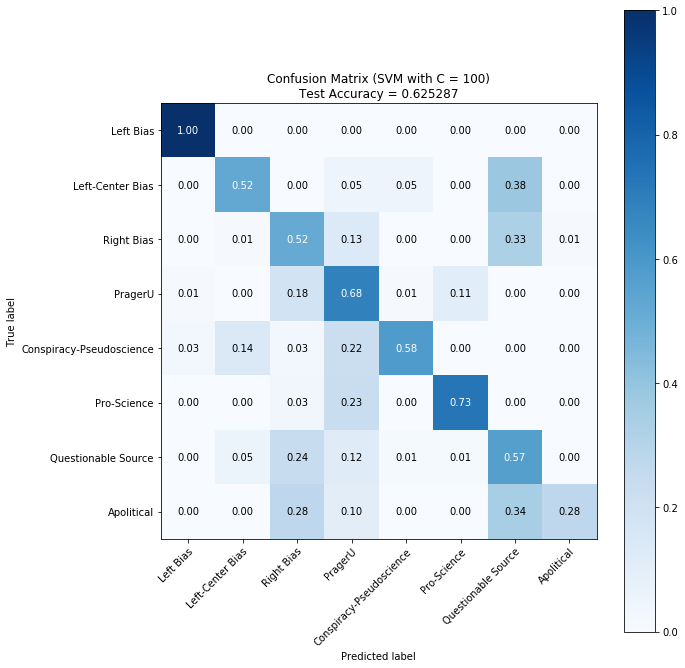

In [99]:
model = train(data_train, label_train, C=100)
acc = metrics.accuracy_score(label_val, model.predict(data_val))
print(acc)
plot_confusion_matrix(label_val, model.predict(data_val), classes=category_encoder.keys(), normalize=True,
                      title='Confusion Matrix (SVM with C = 100)\nTest Accuracy = %f' % acc,
                      outname="c=100SVM.png")

# model = train(data_train, label_train, C=350)
# acc = metrics.accuracy_score(label_val, model.predict(data_val))
# print(acc)
# plot_confusion_matrix(label_val, model.predict(data_val), classes=category_encoder.keys(), normalize=True,
#                       title='Confusion Matrix (SVM with C = 350)\nTest Accuracy = %f' % acc,
#                       outname="c=350SVM.png")


features = ('Num Views', 'Like Count','Dislike Count', 'Profanity Rate', 'Num Comments',
      'Average Comment Length', 'Average Direct Comment Like Count', 
      'Average Thread Length', 'Num Unique Authors', 'Comments Per View')
for i in range(len(model.coef_[0])):
    print("Feature %s had the following weights :" % features[i])
    print(model.coef_[:,i])
    print()

0.7908045977011494
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.76 0.14 0.   0.05 0.   0.05 0.  ]
 [0.   0.02 0.84 0.06 0.   0.   0.07 0.01]
 [0.   0.   0.11 0.73 0.03 0.08 0.03 0.02]
 [0.   0.08 0.03 0.19 0.61 0.   0.08 0.  ]
 [0.   0.   0.   0.13 0.   0.87 0.   0.  ]
 [0.   0.   0.17 0.04 0.05 0.01 0.72 0.  ]
 [0.   0.   0.03 0.07 0.   0.   0.1  0.79]]


{'C': 175,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

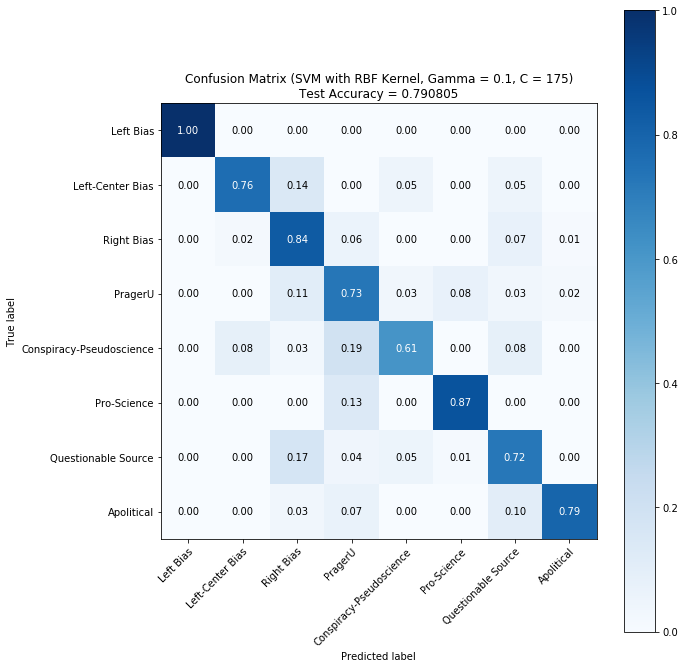

In [100]:
model = train(data_train, label_train, C=175, _kernel='rbf', _gamma = 0.1)
acc = metrics.accuracy_score(label_val, model.predict(data_val))
print(acc)
plot_confusion_matrix(label_val, model.predict(data_val), classes=category_encoder.keys(), normalize=True,
                      title='Confusion Matrix (SVM with RBF Kernel, Gamma = 0.1, C = 175)\nTest Accuracy = %f' % acc,
                      outname="SVMc=175rbf0.1.png")

model.get_params(deep=True)

In [13]:
print(np.shape(data_val))

(435, 10)


In [16]:
import sklearn.tree
def train_tree(X, Y, max_depth):
    model = sklearn.tree.DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X, Y)
    return model

Normalized confusion matrix
[[0.9  0.   0.   0.1  0.   0.   0.   0.  ]
 [0.   0.35 0.18 0.18 0.12 0.   0.12 0.06]
 [0.   0.03 0.71 0.07 0.01 0.   0.17 0.01]
 [0.02 0.01 0.09 0.6  0.06 0.07 0.1  0.05]
 [0.   0.06 0.   0.19 0.58 0.   0.1  0.06]
 [0.   0.03 0.03 0.38 0.   0.51 0.05 0.  ]
 [0.   0.09 0.29 0.06 0.01 0.   0.54 0.01]
 [0.   0.04 0.07 0.11 0.   0.   0.29 0.5 ]]
0.6252873563218391

Importance of Num Views:  0.0861181313447053

Importance of Like Count:  0.2236737624737141

Importance of Dislike Count:  0.11121691604446458

Importance of Profane Rate:  0.14192615507698428

Importance of Num Comments:  0.02265999644695171

Importance of Average Comment Length:  0.07524124903965128

Importance of Average Direct Comment Like Count:  0.08663122453318023

Importance of Average Num Replies:  0.07269412146937754

Importance of Num Unique Authors:  0.04275826116990998

Importance of Comments Per View:  0.13708018240106104



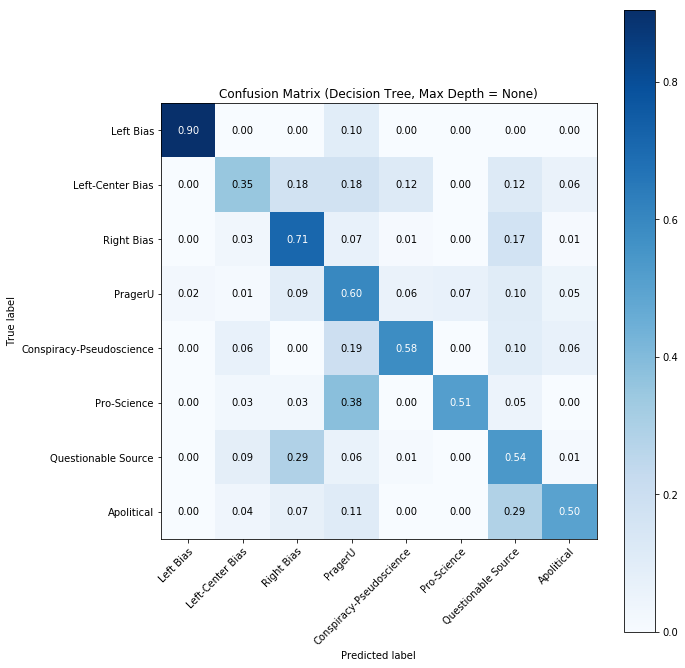

In [17]:
model = train_tree(data_train, label_train, None)
acc = metrics.accuracy_score(label_val, model.predict(data_val))
print(acc)
plot_confusion_matrix(label_val, model.predict(data_val), classes=category_encoder.keys(), normalize=True,
                      title='Confusion Matrix (Decision Tree, Max Depth = None)\nTest Accuracy = %f' % acc,
                     outname="decisiontree_maxdepthnone.png")
print(metrics.accuracy_score(label_val, model.predict(data_val)))
print()
for i, feat in enumerate(features):
    print("Importance of %s: " % feat, model.feature_importances_[i])
    print()

In [18]:
def cv_experiment_tree(training_data, training_labels, k, max_depths):
    num_examples = len(training_data)
    idx = np.random.permutation(num_examples)
    x_parts = [None]*k
    y_parts = [None]*k
    part_size = num_examples // k
    for i in range(k):
        si = i * part_size
        if i == k-1:
            ei = num_examples
        else:
            ei = (i+1) * part_size
        x_parts[i] = training_data[idx][si:ei]
        y_parts[i] = training_labels[idx][si:ei]
    assert np.sum(list(map(lambda x: x.shape[0], x_parts))) == num_examples
    assert np.sum(list(map(lambda x: x.shape[0], y_parts))) == num_examples
    results = []
    for max_depth in max_depths:
        val_scores = []
        for i in range(0, k):
            X_val, Y_val = x_parts[i], y_parts[i]
            X_train = np.concatenate(x_parts[:i] + x_parts[i+1:], axis=0)
            assert X_train.shape[0] + X_val.shape[0] == num_examples
            Y_train = np.concatenate(y_parts[:i] + y_parts[i+1:], axis=0)
            assert Y_train.shape[0] + Y_val.shape[0] == num_examples
            model = train_tree(X_train, Y_train, max_depth)
            val_scores.append(metrics.accuracy_score(Y_val, model.predict(X_val)))
        results.append((max_depth, np.mean(val_scores)))
        print("Max Depth =", results[-1][0], "mean val accuracy: ", results[-1][1])
    return sorted(results, key=lambda x: x[1])[-1][0]

In [101]:
cv_experiment_tree(data_train, label_train, 5, [None] + list(np.arange(8, 15)))

Max Depth = None mean val accuracy:  0.662646875165802
Max Depth = 8 mean val accuracy:  0.6594014390603254
Max Depth = 9 mean val accuracy:  0.664668742679199
Max Depth = 10 mean val accuracy:  0.6711367597063108
Max Depth = 11 mean val accuracy:  0.6707278151668632
Max Depth = 12 mean val accuracy:  0.6743887258643136
Max Depth = 13 mean val accuracy:  0.6699033960354418
Max Depth = 14 mean val accuracy:  0.6687157427322556


12

0.6574712643678161
Normalized confusion matrix
[[0.94 0.   0.   0.02 0.   0.02 0.   0.02]
 [0.   0.48 0.33 0.05 0.   0.   0.05 0.1 ]
 [0.   0.05 0.63 0.06 0.01 0.   0.22 0.03]
 [0.01 0.   0.1  0.63 0.02 0.11 0.08 0.05]
 [0.03 0.06 0.08 0.19 0.56 0.   0.03 0.06]
 [0.   0.   0.1  0.3  0.   0.57 0.03 0.  ]
 [0.   0.01 0.13 0.12 0.01 0.03 0.66 0.04]
 [0.   0.   0.   0.14 0.   0.   0.21 0.66]]
0.6574712643678161



,Feature,Decision Tree Importance
4,Num Comments,0.028195
8,Num Unique Authors,0.029831
7,Average Thread Length,0.066847
6,Average Direct Comment Like Count,0.071287
0,Num Views,0.079629
5,Average Comment Length,0.084224
2,Dislike Count,0.124162
9,Comments Per View,0.133817
3,Profanity Rate,0.158240
1,Like Count,0.223767


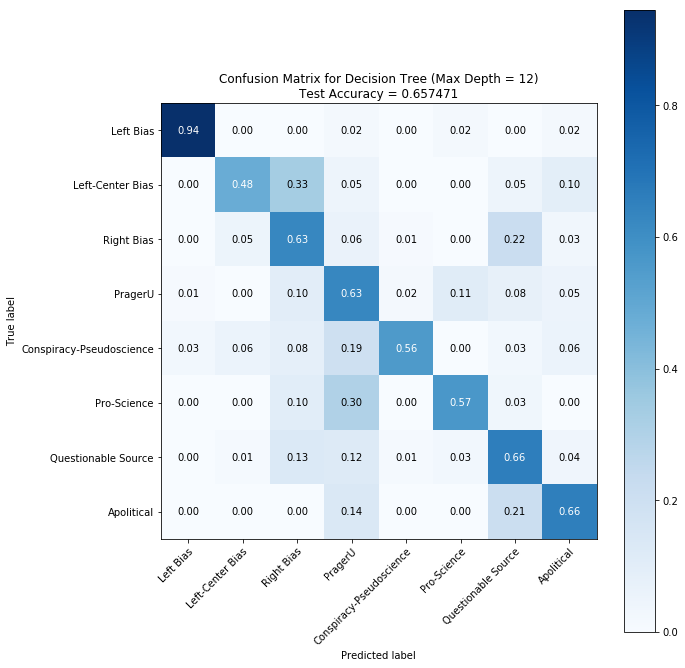

In [105]:
model = train_tree(data_train, label_train, 12)
acc = metrics.accuracy_score(label_val, model.predict(data_val))
print(acc)
plot_confusion_matrix(label_val, model.predict(data_val), classes=category_encoder.keys(), normalize=True,
                      title='Confusion Matrix for Decision Tree (Max Depth = 12)\nTest Accuracy = %f' % acc,
                     outname="decisiontree_maxdepth12.png")
print(metrics.accuracy_score(label_val, model.predict(data_val)))
print()

importance_df = pd.DataFrame(columns=['Feature', 'Decision Tree Importance'])
for i, feat in sorted(enumerate(features), key=lambda x: model.feature_importances_[x[0]]):
    importance_df.loc[i] = [feat, model.feature_importances_[i]]

importance_df

In [59]:
def plot_result(max_depths, title, filename):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.xlabel("Max Depth")
    plt.ylabel("Accuracy")
    val_scores = []
    best = float("-inf")
    bestDepth = None
    for depth in max_depths:
        if depth == 0:
            depth = None
        model = train_tree(data_train, label_train, depth)
        acc = metrics.accuracy_score(label_val, model.predict(data_val))
        val_scores.append(acc)
        if acc > best:
            best = acc
            bestDepth = depth
    print(bestDepth, best)
    plt.plot(max_depths, val_scores)
    plt.savefig(filename)

10 0.6896551724137931


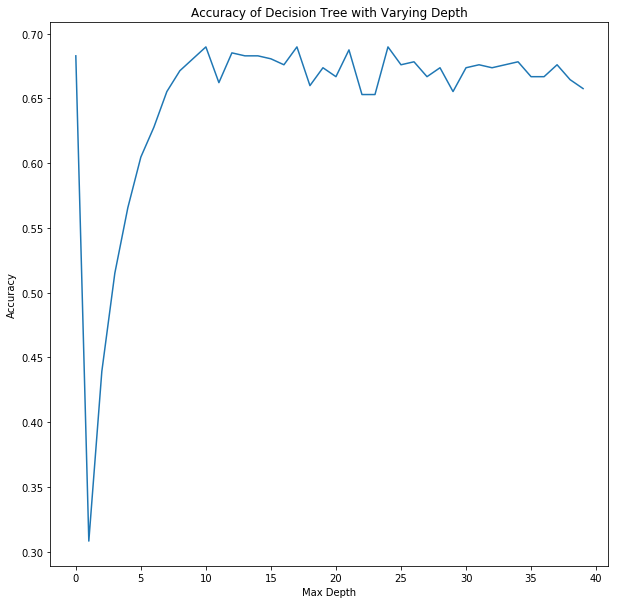

In [60]:
plot_result(np.arange(0, 40), "Accuracy of Decision Tree with Varying Depth", "newest_figures/decision_tree_acc.png")

In [23]:
from sklearn.ensemble import RandomForestClassifier
def train_forest(X, Y, n_estimators, max_depth):
    model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth)
    model.fit(X, Y)
    return model

In [24]:
def cv_experiment_forest(training_data, training_labels, k, n_estimatorss, max_depths):
    num_examples = len(training_data)
    idx = np.random.permutation(num_examples)
    x_parts = [None]*k
    y_parts = [None]*k
    part_size = num_examples // k
    for i in range(k):
        si = i * part_size
        if i == k-1:
            ei = num_examples
        else:
            ei = (i+1) * part_size
        x_parts[i] = training_data[idx][si:ei]
        y_parts[i] = training_labels[idx][si:ei]
    assert np.sum(list(map(lambda x: x.shape[0], x_parts))) == num_examples
    assert np.sum(list(map(lambda x: x.shape[0], y_parts))) == num_examples
    results = []
    for max_depth in max_depths:
        for n_estimators in n_estimatorss:
            val_scores = []
            for i in range(0, k):
                X_val, Y_val = x_parts[i], y_parts[i]
                X_train = np.concatenate(x_parts[:i] + x_parts[i+1:], axis=0)
                assert X_train.shape[0] + X_val.shape[0] == num_examples
                Y_train = np.concatenate(y_parts[:i] + y_parts[i+1:], axis=0)
                assert Y_train.shape[0] + Y_val.shape[0] == num_examples
                model = train_forest(X_train, Y_train, n_estimators, max_depth)
                val_scores.append(metrics.accuracy_score(Y_val, model.predict(X_val)))
            results.append(((n_estimators, max_depth), np.mean(val_scores)))
            print("Num Estimators, Max Depth =", results[-1][0], "mean val accuracy: ", results[-1][1])
    return sorted(results, key=lambda x: x[1])[-1]

In [106]:
cv_experiment_forest(data_train, label_train, 5, np.arange(11, 110, 10), [None] + list(np.arange(2, 13, 2)))

Num Estimators, Max Depth = (11, None) mean val accuracy:  0.74681925222736
Num Estimators, Max Depth = (21, None) mean val accuracy:  0.7512980520037058
Num Estimators, Max Depth = (31, None) mean val accuracy:  0.765487039886377
Num Estimators, Max Depth = (41, None) mean val accuracy:  0.7735908350712796
Num Estimators, Max Depth = (51, None) mean val accuracy:  0.776018382097861
Num Estimators, Max Depth = (61, None) mean val accuracy:  0.7816717750723408
Num Estimators, Max Depth = (71, None) mean val accuracy:  0.7812824206904715
Num Estimators, Max Depth = (81, None) mean val accuracy:  0.7784328690193901
Num Estimators, Max Depth = (91, None) mean val accuracy:  0.7780239244799425
Num Estimators, Max Depth = (101, None) mean val accuracy:  0.7784361340456531
Num Estimators, Max Depth = (11, 2) mean val accuracy:  0.48480171087376184
Num Estimators, Max Depth = (21, 2) mean val accuracy:  0.492512886650532
Num Estimators, Max Depth = (31, 2) mean val accuracy:  0.504182906771256

((61, None), 0.7816717750723408)

0.8022988505747126
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.67 0.14 0.05 0.1  0.   0.   0.05]
 [0.   0.01 0.85 0.05 0.   0.01 0.07 0.01]
 [0.01 0.   0.07 0.78 0.03 0.04 0.03 0.03]
 [0.   0.11 0.   0.08 0.75 0.   0.06 0.  ]
 [0.   0.   0.03 0.13 0.   0.8  0.03 0.  ]
 [0.   0.   0.16 0.04 0.01 0.   0.76 0.03]
 [0.   0.03 0.03 0.07 0.   0.   0.24 0.62]]


,Feature,Decision Tree Importance,Random Forest Importance
4,Num Comments,0.028195,0.067250
6,Average Direct Comment Like Count,0.071287,0.073852
8,Num Unique Authors,0.029831,0.076802
7,Average Thread Length,0.066847,0.079858
5,Average Comment Length,0.084224,0.085174
2,Dislike Count,0.124162,0.098351
0,Num Views,0.079629,0.107514
3,Profanity Rate,0.158240,0.121183
9,Comments Per View,0.133817,0.136023
1,Like Count,0.223767,0.153991


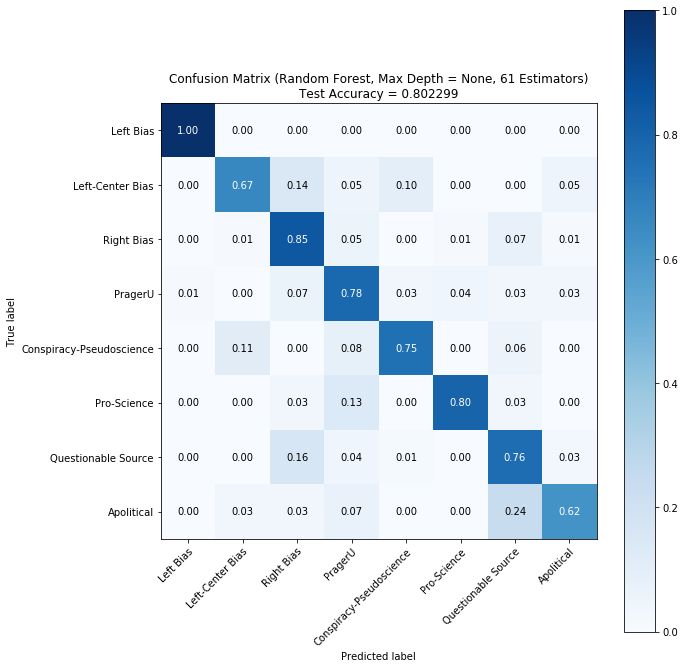

In [107]:
model = train_forest(data_train, label_train, 61, None)
acc = metrics.accuracy_score(label_val, model.predict(data_val))
print(acc)
plot_confusion_matrix(label_val, model.predict(data_val), classes=category_encoder.keys(), normalize=True,
                      title='Confusion Matrix (Random Forest, Max Depth = None, 61 Estimators)\nTest Accuracy = %f' % acc,
                     outname="rf_61-None.png")
importance_df2 = pd.DataFrame(columns=['Feature', 'Decision Tree Importance', 'Random Forest Importance'])
for i, feat in sorted(enumerate(features), key=lambda x: model.feature_importances_[x[0]]):
    importance_df2.loc[i] = [feat, importance_df.loc[importance_df['Feature'] == feat]['Decision Tree Importance'].item(), model.feature_importances_[i]]

importance_df2

In [64]:
from sklearn.manifold import TSNE
embedded_X = TSNE(n_components=3).fit_transform(train_data)
df_subset = pd.DataFrame(columns=['tsne-3d-one', 'tsne-3d-two', 'tsne-3d-three'])
df_subset['tsne-3d-one'] = embedded_X[:,0]
df_subset['tsne-3d-two'] = embedded_X[:,1]
df_subset['tsne-3d-three'] = embedded_X[:,2]

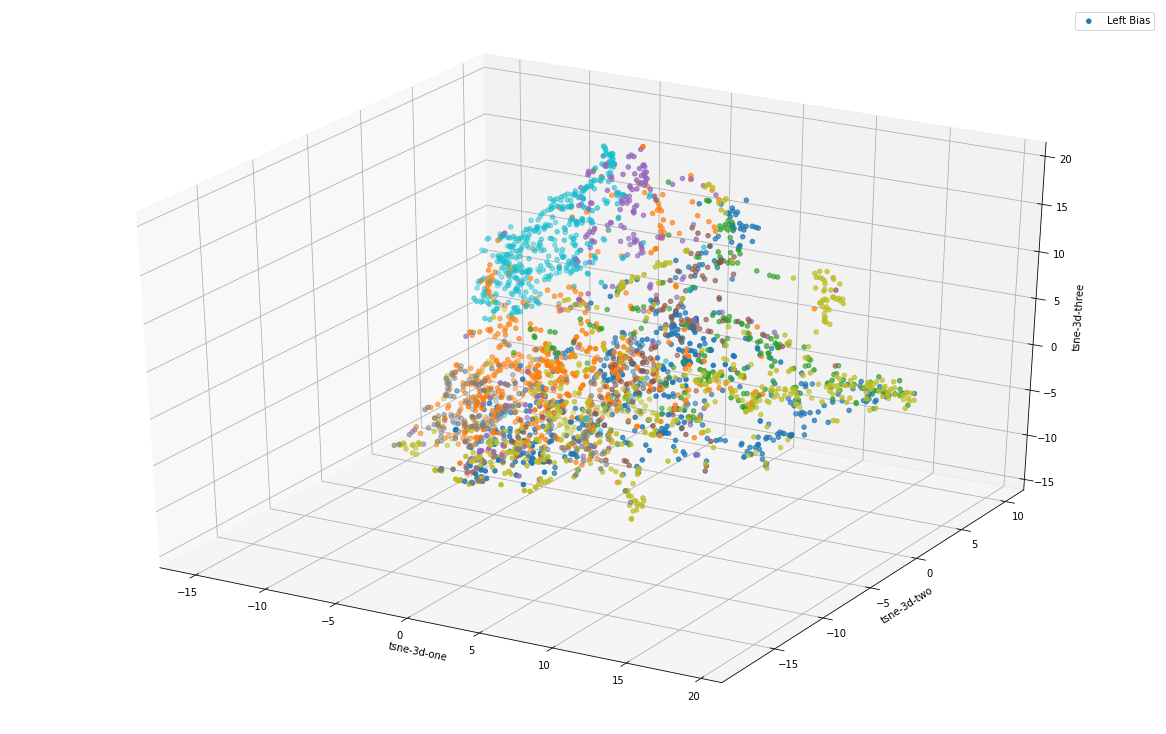

<Figure size 432x288 with 0 Axes>

In [65]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
fig = plt.figure(figsize=(16,10))
ax = Axes3D(fig)
ax.scatter(
    xs=df_subset['tsne-3d-one'], 
    ys=df_subset["tsne-3d-two"], 
    zs=df_subset["tsne-3d-three"], 
    c=[category_encoder[x] for x in LABELS], 
    cmap='tab10'
)
ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')
plt.show()
plt.savefig("newest_figures/tsne3d.png")

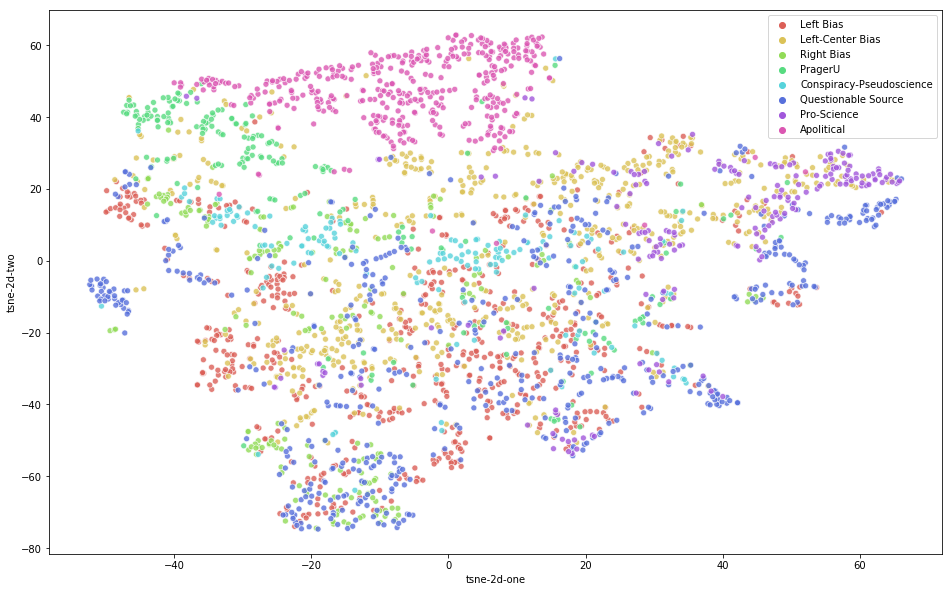

In [66]:
embedded_X = TSNE(n_components=2).fit_transform(train_data)
df_subset = pd.DataFrame(columns=['tsne-2d-one', 'tsne-2d-two'])
df_subset['tsne-2d-one'] = embedded_X[:,0]
df_subset['tsne-2d-two'] = embedded_X[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=LABELS,
    palette=sns.color_palette("hls", 8),
    data=df_subset,
    legend="full",
    alpha=0.8
)
plt.savefig("newest_figures/tsne2d.png")